In [1]:
# Authors: Jessica Su, Wanzi Zhou, Pratyaksh Sharma, Dylan Liu, Ansh Shukla
#Modified: Alex Porter
import numpy as np
import random
import time
import pdb
import unittest
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# Finds the L1 distance between two vectors
# u and v are 1-dimensional np.array objects
def l1(u, v):
    return np.sum(np.abs(u - v))

# Loads the data into a np array, where each row corresponds to
# an image patch -- this step is sort of slow.
# Each row in the data is an image, and there are 400 columns.
def load_data(filename):
    return np.genfromtxt(filename, delimiter=',')

# Creates a hash function from a list of dimensions and thresholds.
def create_function(dimensions, thresholds):
    def f(v):
        boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
        return "".join(map(str, map(int, boolarray)))
    return f

# Creates the LSH functions (functions that compute L K-bit hash keys).
# Each function selects k dimensions (i.e. column indices of the image matrix)
# at random, and then chooses a random threshold for each dimension, between 0 and
# 255.  For any image, if its value on a given dimension is greater than or equal to
# the randomly chosen threshold, we set that bit to 1.  Each hash function returns
# a length-k bit string of the form "0101010001101001...", and the L hash functions 
# will produce L such bit strings for each image.
def create_functions(k, L, num_dimensions=400, min_threshold=0, max_threshold=255):
    functions = []
    for i in range(L):
        dimensions = np.random.randint(low = 0, 
                                   high = num_dimensions,
                                   size = k)
        thresholds = np.random.randint(low = min_threshold, 
                                   high = max_threshold + 1, 
                                   size = k)

        functions.append(create_function(dimensions, thresholds))
    return functions

# Hashes an individual vector (i.e. image).  This produces an array with L
# entries, where each entry is a string of k bits.
def hash_vector(functions, v):
    return np.array([f(v) for f in functions])

# Hashes the data in A, where each row is a datapoint, using the L
# functions in "functions."
def hash_data(functions, A):
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

# Retrieve all of the points that hash to one of the same buckets 
# as the query point.  Do not do any random sampling (unlike what the first
# part of this problem prescribes).
# Don't retrieve a point if it is the same point as the query point.
def get_candidates(hashed_A, hashed_point, query_index):
    return filter(lambda i: i != query_index and \
        any(hashed_point == hashed_A[i]), range(len(hashed_A)))

# Sets up the LSH.  You should try to call this function as few times as 
# possible, since it is expensive.
# A: The dataset in which each row is an image patch.
# Return the LSH functions and hashed data structure.
def lsh_setup(A, k = 24, L = 10):
    functions = create_functions(k = k, L = L)
    hashed_A = hash_data(functions, A)
    return (functions, hashed_A)

# Run the entire LSH algorithm
def lsh_search(A, hashed_A, functions, query_index, num_neighbors = 10):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)
    
    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]

    return [t[0] for t in best_neighbors]

# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save(base_filename + "-" + str(row_num) + ".png")

# Finds the nearest neighbors to a given vector, using linear search.
def linear_search(A, query_index, num_neighbors):
    distances = [(i, l1(A[i], A[query_index])) for i in range(len(A)) if i != query_index]
    return [t[0] for t in sorted(distances, key=lambda x: x[1])[:num_neighbors]]

## Search time

In [29]:
# Load data
data = load_data("data/patches.csv")

In [30]:
# Set up LSH
functions, hashed_data = lsh_setup(data, k=k, L=L)

# Define query indices
query_indices = list(range(100, 1001, 100))

# Initialize lists to store search times
lsh_times = []
linear_times = []

for query_index in query_indices:
    # LSH search
    start_time = time.time()
    lsh_result = lsh_search(data, hashed_data, functions, query_index, 3)
    lsh_time = time.time() - start_time
    lsh_times.append(lsh_time)

    # Linear search
    start_time = time.time()
    linear_result = linear_search(data, query_index, 3)
    linear_time = time.time() - start_time
    linear_times.append(linear_time)

 # Compute average search times
avg_lsh_time = np.mean(lsh_times)
avg_linear_time = np.mean(linear_times)

In [31]:
avg_lsh_time

0.11772582530975342

In [32]:
avg_linear_time

0.43913044929504397

## Error measure

In [9]:
num_neighbors = 3
L_values = list(range(10, 21, 2))
errors_L = []

for L in L_values:
    print("Processing L =", L, "and k = 24")

    # Set up LSH
    functions, hashed_data = lsh_setup(data, k=24, L=L)

    # Initialize lists to store results
    lsh_results = []
    linear_results = []

    # Set query indices
    query_indices = list(range(100, 1001, 100))

    for query_index in query_indices:
        # LSH search
        lsh_result = lsh_search(data, hashed_data, functions, query_index, num_neighbors)
        lsh_results.append(lsh_result)

        # Linear search
        linear_result = linear_search(data, query_index, num_neighbors)
        linear_results.append(linear_result)

    # Compute error measure
    error_measure = compute_error_measure(query_indices, lsh_results, linear_results)

    # Store error measure
    errors_L.append(error_measure)


Processing L = 10 and k = 24
Processing L = 12 and k = 24
Processing L = 14 and k = 24
Processing L = 16 and k = 24
Processing L = 18 and k = 24
Processing L = 20 and k = 24


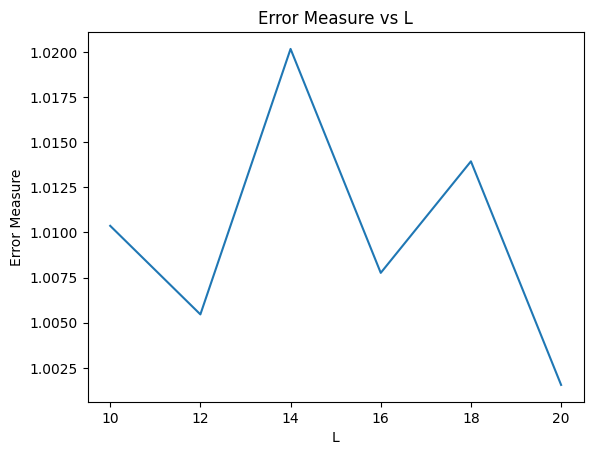

In [17]:
# Plot error value as a function of L
plt.plot(L_values, errors_L)
plt.xlabel('L')
plt.ylabel('Error Measure')
plt.title('Error Measure vs L')
plt.savefig("errorL")

In [13]:
num_neighbors = 3
k_values = list(range(16, 25, 2))
errors_k = []

for k in k_values:
    print("Processing L = 10 and k = ", k)

    functions, hashed_data = lsh_setup(data, k=k, L=10)
    lsh_results = []
    linear_results = []
    query_indices = list(range(100, 1001, 100))

    for query_index in query_indices:
        lsh_result = lsh_search(data, hashed_data, functions, query_index, num_neighbors)
        lsh_results.append(lsh_result)
        linear_result = linear_search(data, query_index, num_neighbors)
        linear_results.append(linear_result)

    error_measure = compute_error_measure(query_indices, lsh_results, linear_results)
    errors_k.append(error_measure)

Processing L = 10 and k =  16
Processing L = 10 and k =  18
Processing L = 10 and k =  20
Processing L = 10 and k =  22
Processing L = 10 and k =  24


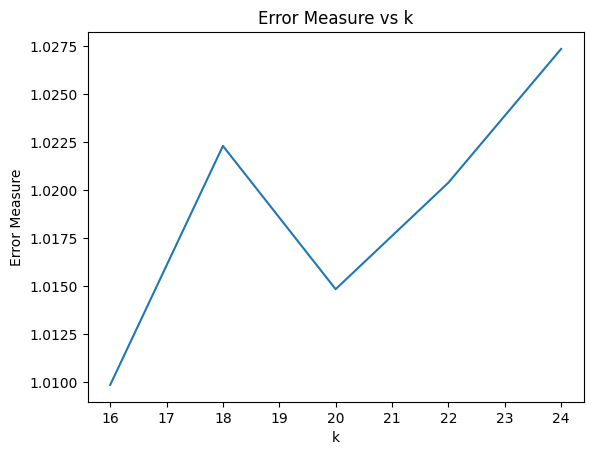

In [16]:
# Plot error value as a function of k
plt.plot(k_values, errors_k)
plt.xlabel('k')
plt.ylabel('Error Measure')
plt.title('Error Measure vs k')
plt.savefig("errork")

## Top 10 near neighbours

In [18]:
L = 10
k = 24
num_neighbors = 10
functions, hashed_data = lsh_setup(data, k=k, L=L)
query_index = 99  

lsh_results = lsh_search(data, hashed_data, functions, query_index, num_neighbors)
linear_results = linear_search(data, query_index, num_neighbors)

In [26]:
# Plot the original image patch
plot(data, [query_index], "original_patch")

In [27]:
# Plot the top 10 near neighbors found using LSH
plot(data, lsh_results, "lsh_near_neighbors")

In [28]:
# Plot the top 10 near neighbors found using linear search
plot(data, linear_results, "linear_near_neighbors")